root
 |-- Ticker: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Close/Last: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)

+------+----------+----------+--------+--------+--------+--------+
|Ticker|      Date|Close/Last|  Volume|    Open|    High|     Low|
+------+----------+----------+--------+--------+--------+--------+
|  AAPL|05/31/2023|  $177.25 |99625290|$177.33 |$179.35 |$176.76 |
|  AAPL|05/30/2023|  $177.30 |55964400|$176.96 |$178.99 |$176.57 |
|  AAPL|05/26/2023|  $175.43 |54834980|$173.32 |$175.77 |$173.11 |
|  AAPL|05/25/2023|  $172.99 |56058260|$172.41 |$173.90 |$171.69 |
|  AAPL|05/24/2023|  $171.84 |45143490|$171.09 |$172.42 |$170.52 |
+------+----------+----------+--------+--------+--------+--------+
only showing top 5 rows

root
 |-- Ticker: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Close: string (nulla

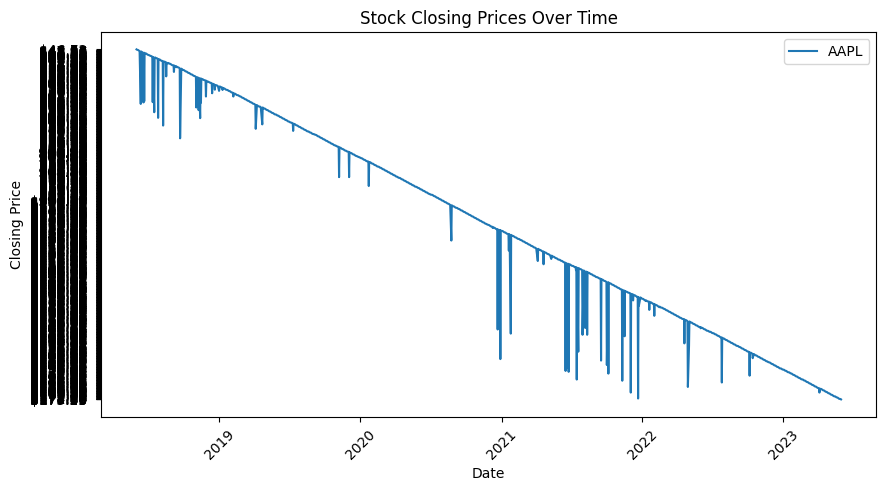

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, max, min, to_date

# Initialize Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BigDataAnalysis") \
    .config("spark.driver.memory", "4G") \
    .getOrCreate()

# Read CSV file into a PySpark DataFrame
df = spark.read.csv("/content/AAPL.csv", header=True, inferSchema=True)

# Show schema and first few rows
df.printSchema()
df.show(5)

# Convert 'Date' column to proper date format
df = df.withColumn("ParsedDate", to_date(col("Date"), "MM/dd/yyyy"))

# Fix column names: Rename 'Close/Last' to 'Close' and 'Volume' to 'TradeVolume'
df = df.withColumnRenamed("Close/Last", "Close") \
       .withColumnRenamed("Volume", "TradeVolume")

# Show corrected schema
df.printSchema()

# Aggregation: Average Volume
df_grouped = df.groupBy("Ticker").agg(avg("TradeVolume").alias("Avg_Volume"))
df_grouped.show()

# Maximum closing price per ticker
# Use the renamed 'Close' column
df_max_close = df.groupBy("Ticker").agg(max("Close").alias("Max_Close"))
df_max_close.show()

# Filter stocks where Close price > 320
# Use the renamed 'Close' column
filtered_df = df.filter(col("Close") > 320)
filtered_df.show(5)

# Repartitioning for scalability
df_repartitioned = df.repartition(10)
print(f"Number of partitions: {df_repartitioned.rdd.getNumPartitions()}")

# Convert to Pandas for visualization
df_pandas = df.toPandas()

# Plot closing price trends
plt.figure(figsize=(10,5))
for ticker in df_pandas["Ticker"].unique():
    subset = df_pandas[df_pandas["Ticker"] == ticker]
    plt.plot(subset["ParsedDate"], subset["Close"], label=ticker)

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Closing Prices Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Stop Spark Session
spark.stop()
